# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Preprocessing

## Preprocessing imports

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
# infile_dataset = open(f'data/low_q_binned_weights_1000.pkl', 'rb')
# infile_dataset = open(f'data/low_q_binned_weights_1000_new_samples.pkl', 'rb')
# infile_dataset = open(f'data/dataset_1_19_20_local.pkl', 'rb')
# infile_dataset = open(f'data/low_q_binned_weights_big_interp.pkl', 'rb')
infile_dataset = open(f'data/binned_interp_10000n_10000points_10bins_.pkl', 'rb')

dataset_1 = pickle.load(infile_dataset)
infile_dataset.close()

In [5]:
# qkl_histograms = np.array([x['histogram_qkl'] for x in dataset_1])
qkl_histograms_interp = np.array([x['histogram_qkl_interp'] for x in dataset_1])
qkl_coefficients = np.array([[x['c9'], x['c10']] for x in dataset_1])

qkl_histograms, qkl_histograms_reserved = qkl_histograms_interp[:-10], qkl_histograms_interp[-9:]
qkl_coefficients, qkl_coefficients_reserved = qkl_coefficients[:-10], qkl_coefficients[-9:]

X_train, X_test, y_train, y_test = train_test_split(qkl_histograms, qkl_coefficients, test_size=0.25)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],X_train.shape[2], X_train.shape[3], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],X_test.shape[2], X_test.shape[3], 1)

## EDA

In [12]:
n_bins = 10
bin_edges_ql = [
    np.linspace(0.5, 6, n_bins+1),           # q2
    np.linspace(0, np.pi, n_bins+1),         # l
]
bin_edges_kl = [
    np.linspace(0, np.pi, n_bins+1),         # k
    np.linspace(0, np.pi, n_bins+1),         # l
]
bin_edges_qkl = [
    np.linspace(0.5, 6, n_bins+1),           # q2
    np.linspace(0, np.pi, n_bins+1),         # k
    np.linspace(0, np.pi, n_bins+1),         # l
]

bin_centres_3d = [(edges[:-1] + edges[1:]) / 2 for edges in bin_edges_qkl]

x, y, z = np.meshgrid(*bin_centres_3d)

<ipython-input-13-8ee3f9911a31>:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


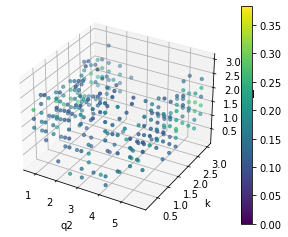

In [13]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

iii = 3
# ex_grid = qkl_histograms[iii]
ex_grid_interp = qkl_histograms_interp[iii]
# ex_grid_diff = ex_grid - ex_grid_interp

# im = ax.scatter(x, y, z, c = ex_grid_diff, s=np.where(ex_grid_diff > 1e-3, 10, 0))
# im = ax.scatter(x, y, z, c = ex_grid, s=np.where(ex_grid > 1e-2, 10, 0))
im = ax.scatter(x, y, z, c = ex_grid_interp, s=np.where(ex_grid_interp > 10e-2, 10, 0))
ax.set_xlabel('q2')
ax.set_ylabel('k')
ax.set_zlabel('l')

fig.colorbar(im)

fig.show()

# Model Creation and Evaluation

## ML Imports

In [14]:
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.metrics import r2_score

## Modelling

### 3D CNN

In [15]:
model_3d = keras.Sequential()

# Convolutional part
model_3d.add(layers.Conv3D(10, (3,3,3), activation='relu', input_shape=(10,10,10,1)))
model_3d.add(layers.MaxPool3D((2,2,2)))
model_3d.add(layers.Conv3D(20, (3,3,3), activation='relu'))

# Dense part
model_3d.add(layers.Dense(10, activation='relu'))
model_3d.add(layers.Flatten())
model_3d.add(layers.Dense(2, activation='linear'))

model_3d.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_squared_error']
)

In [18]:
history = model_3d.fit(
    X_train, 
    y_train,
    # batch_size=10,
    epochs=10,
    validation_data=(X_test, y_test)
)

Epoch 1/10
235/235 [==============================] - 5s 23ms/step - loss: 0.2145 - mean_squared_error: 0.2145 - val_loss: 0.2221 - val_mean_squared_error: 0.2221
Epoch 2/10
235/235 [==============================] - 5s 22ms/step - loss: 0.2082 - mean_squared_error: 0.2082 - val_loss: 0.2068 - val_mean_squared_error: 0.2068
Epoch 3/10
235/235 [==============================] - 5s 22ms/step - loss: 0.2009 - mean_squared_error: 0.2009 - val_loss: 0.2033 - val_mean_squared_error: 0.2033
Epoch 4/10
235/235 [==============================] - 5s 23ms/step - loss: 0.1984 - mean_squared_error: 0.1984 - val_loss: 0.1985 - val_mean_squared_error: 0.1985
Epoch 5/10
235/235 [==============================] - 5s 22ms/step - loss: 0.1944 - mean_squared_error: 0.1944 - val_loss: 0.1926 - val_mean_squared_error: 0.1926
Epoch 6/10
235/235 [==============================] - 5s 23ms/step - loss: 0.1873 - mean_squared_error: 0.1873 - val_loss: 0.1896 - val_mean_squared_error: 0.1896
Epoch 7/10
235/235 [==

In [19]:
pred = model_3d.predict(X_test)

print(f'R^2    - {r2_score(pred, y_test)}')
print(f'R^2(a) - {r2_score(pred[:,0], y_test[:,0])}')
print(f'R^2(b) - {r2_score(pred[:,1], y_test[:,1])}')

R^2    - 0.9334611105792678
R^2(a) - 0.9601007143323903
R^2(b) - 0.9068215062526876


[[ 0.42856112 -2.5838695 ]]


<ipython-input-26-3eb9c651138e>:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


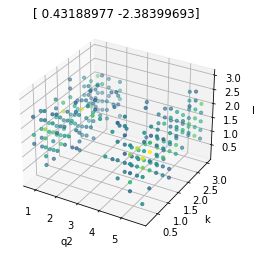

In [26]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

iii = 100
ex_grid = X_test[iii].reshape(10,10,10)

print(model_3d.predict(np.array([X_test[iii]])))

ax.scatter(x, y, z, c = ex_grid, s=np.where(ex_grid > 10e-2, 10, 0))
ax.set_xlabel('q2')
ax.set_ylabel('k')
ax.set_zlabel('l')
ax.set_title(y_test[iii])
fig.show()

#### Export model

In [27]:
model_3d.save('models/model_3d_10bins_10000n')


INFO:tensorflow:Assets written to: models/model_3d_10bins_10000n/assets


### 3D Dense

In [28]:
model_3d_dense = keras.Sequential()

# Dense part
model_3d_dense.add(layers.Dense(100, activation='relu'))
model_3d_dense.add(layers.Dense(100, activation='relu'))
model_3d_dense.add(layers.Flatten())
model_3d_dense.add(layers.Dense(2, activation='linear'))

model_3d_dense.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_squared_error']
)

In [31]:
history = model_3d_dense.fit(
    X_train, 
    y_train,
    # batch_size=10,
    epochs=10,
    validation_data=(X_test, y_test)
)

Epoch 1/10
235/235 [==============================] - 6s 28ms/step - loss: 0.1786 - mean_squared_error: 0.1786 - val_loss: 0.2299 - val_mean_squared_error: 0.2299
Epoch 2/10
235/235 [==============================] - 8s 32ms/step - loss: 0.1733 - mean_squared_error: 0.1733 - val_loss: 0.2440 - val_mean_squared_error: 0.2440
Epoch 3/10
235/235 [==============================] - 8s 33ms/step - loss: 0.1755 - mean_squared_error: 0.1755 - val_loss: 0.2697 - val_mean_squared_error: 0.2697
Epoch 4/10
235/235 [==============================] - 7s 31ms/step - loss: 0.1689 - mean_squared_error: 0.1689 - val_loss: 0.2540 - val_mean_squared_error: 0.2540
Epoch 5/10
235/235 [==============================] - 8s 34ms/step - loss: 0.1652 - mean_squared_error: 0.1652 - val_loss: 0.2448 - val_mean_squared_error: 0.2448
Epoch 6/10
235/235 [==============================] - 8s 35ms/step - loss: 0.1651 - mean_squared_error: 0.1651 - val_loss: 0.2706 - val_mean_squared_error: 0.2706
Epoch 7/10
235/235 [==

In [32]:
pred = model_3d_dense.predict(X_test)

print(f'R^2    - {r2_score(pred, y_test)}')
print(f'R^2(a) - {r2_score(pred[:,0], y_test[:,0])}')
print(f'R^2(b) - {r2_score(pred[:,1], y_test[:,1])}')

R^2    - 0.915214689841789
R^2(a) - 0.9392871665300626
R^2(b) - 0.8911422131746529


#### Export model

In [33]:
model_3d_dense.save('models/model_3d_10bins_10000n')

INFO:tensorflow:Assets written to: models/model_3d_10bins_10000n/assets


# Verify with new data

In [100]:
sample_path = '/Users/oskar/MSci/new-physics/toy_data/flavio_tests/data/'
# sample_filename = 'toy_data_c9_0.43_c10_0.17_2022_1_16_0.csv'
# sample_filename = '../../data_generation/data/datasets/toy_data_c9_1.0_c10_-2.0_2022_1_31_0.csv'
# sample_filename = '../../data_generation/data/datasets/toy_data_c9_1.0_c10_1.5_2022_1_31_0.csv'
sample_filename = '../../data_generation/data/datasets/toy_data_c9_1.0_c10_0.5_2022_1_31_0.csv'
sample = pd.read_csv(sample_path + sample_filename)

# sample_path = '/Users/oskar/MSci/new-physics/toy_data/wilson_regression/data/'
# sample_filename_sm = 'low_q_with_weights.csv'
# sample_sm = pd.read_csv(sample_path + sample_filename_sm)

In [101]:
n_bins = 10

bin_edges_qkl = [
    np.linspace(0.5, 6, n_bins+1),           # q2
    np.linspace(0, np.pi, n_bins+1),         # k
    np.linspace(0, np.pi, n_bins+1),         # l
]

values_3d_qkl, _ = np.histogramdd(
    sample[['q2', 'k', 'l']].sample(10000).values,
    bins=bin_edges_qkl,
    # weights=sample_sm['scenario_8_w'].iloc[:5000],
    density=True
)

[[0.44919023 0.10710157]]


<ipython-input-102-2092ee533f38>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


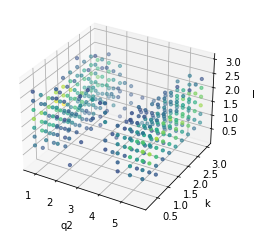

In [102]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ex_grid = values_3d_qkl
# ex_grid = qkl_histograms_reserved[]

# print(qkl_coefficients_reserved[])

print(model_3d.predict(np.array([ex_grid.reshape(10,10,10,1)])))

ax.scatter(x, y, z, c = ex_grid, s=np.where(ex_grid > 2e-2, 10, 0))
ax.set_xlabel('q2')
ax.set_ylabel('k')
ax.set_zlabel('l')

fig.show()

# Error evaluation

In [103]:
n_bins = 10

bin_edges_qkl = [
    np.linspace(0.5, 2, n_bins+1),           # q2
    np.linspace(0, np.pi, n_bins+1),         # k
    np.linspace(0, np.pi, n_bins+1),         # l
]

values_3d_qkl, _ = np.histogramdd(
    sample[['q2', 'k', 'l']].values[:5000],
    bins=bin_edges_qkl,
    # weights=sample_sm['scenario_8_w'].iloc[:5000],
    density=True
)

model_3d.predict(np.array([ex_grid.reshape(10,10,10,1)]))


array([[0.44919023, 0.10710157]], dtype=float32)

In [104]:
n_bins = 10
error_samples = 1000
error_sample_size = 10000

bin_edges_qkl = [
    np.linspace(0.5, 2, n_bins+1),           # q2
    np.linspace(0, np.pi, n_bins+1),         # k
    np.linspace(0, np.pi, n_bins+1),         # l
]

predictions = []

for _ in range(error_samples):
    error_sample = sample[['q2', 'k', 'l']].sample(error_sample_size).values

    error_sample_hist, _ = np.histogramdd(
        error_sample,
        bins=bin_edges_qkl,
        # weights=sample_sm['scenario_8_w'].iloc[:5000],
        density=True
    )

    error_prediction = model_3d.predict(np.array([error_sample_hist.reshape(n_bins,n_bins,n_bins,1)]))

    predictions.append(error_prediction[0])

predictions = np.array(predictions)

In [105]:
predictions[:,0].mean(), predictions[:,1].mean()

(0.9932239, 0.41018817)

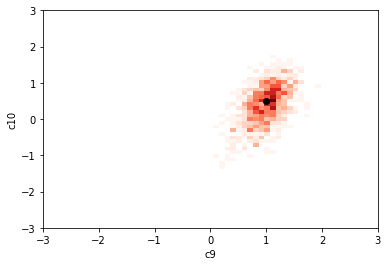

In [107]:
bins = np.linspace(-3,3,60)
plt.hist2d(predictions[:,0], predictions[:,1], bins=(bins, bins),cmap=plt.cm.Reds, cmin=1)
plt.scatter([1], [0.5], c='black')
# plt.scatter([0.5], [1])
plt.xlabel('c9')
plt.ylabel('c10')
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.show()

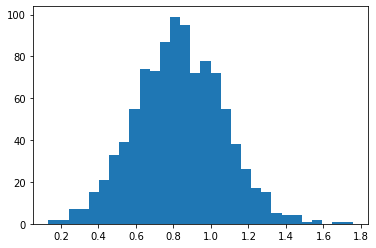

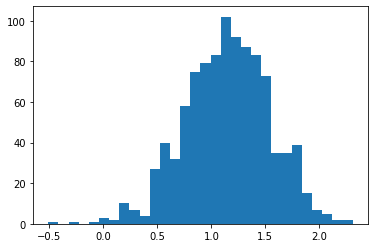

In [87]:
plt.hist(predictions[:,0], bins=30)
plt.show()
plt.hist(predictions[:,1], bins=30)
plt.show()

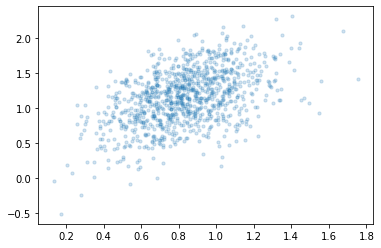

In [88]:
plt.scatter(predictions[:,0], predictions[:,1], s=10, alpha=0.2)